In [25]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.pipeline import make_pipeline

import os

import skimage
import skimage.color
import skimage.transform
import skimage.io
import skimage.feature

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
class rgb2gray_transform(BaseEstimator,TransformerMixin):
    import skimage.color
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return np.array([skimage.color.rgb2gray(x) for x in X])

In [6]:
class hogtransformer(BaseEstimator,TransformerMixin):
    import skimage.feature
    def __init__(self,orientations=9,pixels_per_cell=(8,8),cells_per_block=(3, 3)):
        self.orientations=orientations
        self.pixels_per_cell=pixels_per_cell
        self.cells_per_block=cells_per_block
    
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        def local_hog(img):
            hog_features= skimage.feature.hog(img,
                               orientations=self.orientations,
                               pixels_per_cell=self.pixels_per_cell,
                               cells_per_block=self.cells_per_block)
            return hog_features
        
        features = np.array([local_hog(x) for x in X])
#         hog_images= np.array([local_hog(x) for x in X])
        return features
        

## Pipeline Model

In [55]:
# read the image
image = skimage.io.imread('eagle.jpg')
# transfrom image into 80x80
image_resized = skimage.transform.resize(image,(80,80))
# rescale
rescaled_image = 255*image_resized

image_transformed = rescaled_image.astype(np.uint8) # converting to 8 bit integer

# rgb2gray 
gray = skimage.color.rgb2gray(image_transformed) # can use custom function as well
# graify = rgb2gray_transform()
# gray = graify.fit_transform(image_transformed)

# hog feature (choosing best hyperparameter)

hog_feature_vector = skimage.feature.hog(gray,
                                  orientations=10, pixels_per_cell=(8,8),cells_per_block=(3,3))

# hog = hogtransformer(orientations=8, pixels_per_cell=(8,8),cells_per_block=(3,3))
# hog_feature_vector = hog.fit_transform(gray)



In [56]:
hog_feature_vector.reshape(1,-1)

array([[0.01633377, 0.00198746, 0.03191212, ..., 0.02345522, 0.01844644,
        0.00353701]])

In [57]:
#  rescaled_image  # float value messed all our image
image_transformed

array([[[ 4, 17,  0],
        [ 5, 18,  0],
        [ 6, 19,  1],
        ...,
        [ 7, 18,  1],
        [ 6, 17,  0],
        [ 6, 16,  0]],

       [[ 6, 20,  0],
        [ 6, 20,  0],
        [ 7, 22,  0],
        ...,
        [ 7, 18,  1],
        [ 7, 16,  0],
        [ 6, 15,  0]],

       [[ 7, 22,  0],
        [ 8, 23,  0],
        [ 8, 24,  0],
        ...,
        [ 7, 17,  0],
        [ 7, 15,  0],
        [ 6, 14,  0]],

       ...,

       [[ 0,  7,  0],
        [ 0,  6,  0],
        [ 0,  6,  0],
        ...,
        [ 4,  6,  1],
        [ 7,  8,  3],
        [10,  9,  4]],

       [[ 0,  7,  0],
        [ 0,  6,  0],
        [ 0,  6,  0],
        ...,
        [ 3,  5,  0],
        [ 5,  6,  1],
        [ 8,  9,  4]],

       [[ 0,  7,  0],
        [ 0,  7,  0],
        [ 0,  7,  0],
        ...,
        [ 4,  6,  1],
        [ 4,  5,  0],
        [ 7,  7,  3]]], dtype=uint8)

In [58]:
## load the scaler model

In [51]:
scaler = pickle.load(open('dsa_scaler.pickle','rb'))
model = pickle.load(open('image_classification_sgd.pickle','rb'))

In [52]:
model.get_params()

{'alpha': 0.01,
 'average': False,
 'class_weight': None,
 'early_stopping': True,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [59]:
scaled = scaler.transform(hog_feature_vector.reshape(1,-1))
y_pred = model.predict(scaled)

In [60]:
y_pred

array(['eagle'], dtype='<U8')

### Calculating the Probability

In [111]:
# decision calculates the confidence socre for each class

decision_value = model.decision_function(scaled)
# decision_value = np.abs(decision_value)
decision_value_scaled = decision_value/1e+12

In [112]:
decision_value_scaled

array([[-216.3331827 , -199.48483375, -153.45888564, -114.94607211,
        -263.32049121, -171.07003441,  -79.7158647 ,  -18.20185262,
        -258.06633431, -182.93515082, -220.70402848, -121.18309559,
        -294.4631485 , -222.56935518,  -96.43921628,  -32.27545148,
        -235.95623085, -210.14286616, -148.10484027, -365.73817901]])

In [118]:
labels = model.classes_
labels

array(['bear', 'cat', 'chicken', 'cow', 'deer', 'dog', 'duck', 'eagle',
       'elephant', 'human', 'lion', 'monkey', 'mouse', 'natural', 'panda',
       'pigeon', 'rabbit', 'sheep', 'tiger', 'wolf'], dtype='<U8')

In [114]:
decision_value=decision_value.flatten()

(array([-4.0e+14, -3.5e+14, -3.0e+14, -2.5e+14, -2.0e+14, -1.5e+14,
        -1.0e+14, -5.0e+13,  0.0e+00]),
 <a list of 9 Text major ticklabel objects>)

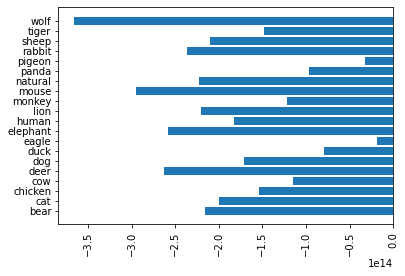

In [115]:
plt.barh(labels,decision_value,)
plt.xticks(rotation=90)


In [116]:
## calculate z-score

z = scipy.stats.zscore(decision_value)
z

array([-0.42461096, -0.22631705,  0.31537789,  0.7686482 , -0.97762047,
        0.10810633,  1.18328442,  1.90726361, -0.91578252, -0.03153824,
       -0.47605292,  0.69524256, -1.34414892, -0.49800658,  0.98646164,
        1.74162667, -0.65556124, -0.35175503,  0.37839146, -2.18300884])

In [117]:
prob = scipy.special.softmax(z)
prob

array([0.020114  , 0.02452541, 0.04215717, 0.06633217, 0.01156989,
       0.0342653 , 0.10041497, 0.20711837, 0.01230794, 0.02979941,
       0.01910546, 0.06163744, 0.00801951, 0.01869059, 0.08247445,
       0.17550254, 0.01596607, 0.02163412, 0.04489913, 0.00346606])

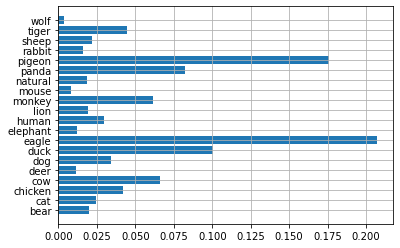

In [119]:
plt.barh(labels,prob)
plt.grid()

In [120]:
## top-5 prob values

In [125]:
top_5_prob_index = prob.argsort()[::-1][:5]
top_5_prob_index

array([ 7, 15,  6, 14,  3])

In [127]:
top_labels = labels[top_5_prob_index]

In [128]:
top_5_prob_values = prob[top_5_prob_index]

In [129]:
top_5_prob_values

array([0.20711837, 0.17550254, 0.10041497, 0.08247445, 0.06633217])

In [132]:
top_dict = dict()
for key,value in zip(top_labels,top_5_prob_values):
    top_dict[key]=np.round(value,2)

In [133]:
top_dict

{'eagle': 0.21, 'pigeon': 0.18, 'duck': 0.1, 'panda': 0.08, 'cow': 0.07}

## making pipeline function

In [136]:
def pipe_fun(path,scaler_transformed,model_sgd):
    # read the image
    image = skimage.io.imread(path)
    # making transformation
    image_resized = skimage.transform.resize(image,(80,80))
    # rescaling
    rescaled_image = 255*image_resized
    image_transformed = rescaled_image.astype(np.uint8) # converting to 8 bit integer
    # graify
    gray = skimage.color.rgb2gray(image_transformed) # can use custom function as well
    # hog feature extraction
    hog_feature_vector = skimage.feature.hog(gray,
                                  orientations=10, pixels_per_cell=(8,8),cells_per_block=(3,3))
    
    #scaling
    scaled = scaler_transformed.transform(hog_feature_vector.reshape(1,-1))
    y_pred = model_sgd.predict(scaled)
    # confidence score for each class
    decision_value = model_sgd.decision_function(scaled)
    decision_value=decision_value.flatten()
    labels = model_sgd.classes_
    # probabilty 
    z = scipy.stats.zscore(decision_value)
    prob = scipy.special.softmax(z)
    top_5_prob_index = prob.argsort()[::-1][:5]
    top_5_prob_values = prob[top_5_prob_index]
    #making dictionary
    top_dict = dict()
    for key,value in zip(top_labels,top_5_prob_values):
        top_dict[key]=np.round(value,2)
    
    return top_dict

In [135]:
pipe_fun('eagle.jpg',scaler,model)

{'eagle': 0.21, 'pigeon': 0.18, 'duck': 0.1, 'panda': 0.08, 'cow': 0.07}